In [1]:
import sys,os
import glob
import torch,dill
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from iresnet import iResBlock
from spectral_norm import SN
import torch.nn as nn
import torch.nn.functional as F
import scipy as sp
import numpy as np
import seaborn as sb
import pandas as pd
%load_ext line_profiler
torch.backends.cudnn.enabled = False

In [2]:
paths = glob.glob(os.path.expanduser('~/tb-experiments/elu_flow/**/*.trainer'),recursive=True)#glob.glob(os.path.expanduser('~/tb-experiments/iresnet_WTW/**/*.trainer'),recursive=True)
print(paths)

['/home/marc/tb-experiments/elu_flow/CIFAR10/iEluNet/trial0/checkpoints/c10.trainer']


In [3]:
trainer = torch.load(paths[-1],pickle_module=dill)
trainer.model.eval();

/home/marc/anaconda3/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'iEluNetwork.iEluNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/marc/anaconda3/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'iEluNetwork.iConv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [23]:
def eigh(mat):
    #print(mat.shape)
    return sp.linalg.eigh(mat,eigvals_only=True)

def singularValues(kernel,input_shape):
    transforms = np.fft.fft2(kernel,input_shape,axes=(0,1))
    u,s,vh = np.linalg.svd(transforms)#,compute_uv=False)
    return s
def singularValues2(kernel,input_shape):
    #print(kernel.shape)
    transforms = M= np.fft.fft2(kernel,input_shape,axes=(0,1))
    c = M.shape[-1]
    MtM = (M@M).reshape(-1,c,c)
    #print(MtM.shape)
    #eigh = lambda mat: sp.linalg.eigh(mat,eigvals=(c-1,c-1),eigvals_only=True)
    s = []
    for N in MtM:
        s.append(sp.linalg.eigh(N,eigvals=(c-1,c-1),eigvals_only=True))
    eigs = np.array(s)
    print(eigs.shape)
    return eigs
    #eigs = np.vectorize(eigh)(MtM)#np.apply_along_axis(eigh,0,MtM)
    print(eigs.shape)
#     A = np.real(transforms)
#     B = np.imag(transforms)
#     A_mB = np.concatenate((A,-B),axis=3).astype(np.float32)
#     B_A = np.concatenate((B,A),axis=3).astype(np.float32)
#     embedded_matrix = np.concatenate((A_mB,B_A),axis=2)
#     h,w,c2,_ = embedded_matrix.shape
#     M = torch.from_numpy(embedded_matrix.reshape(-1,c2,c2)).cuda()
#     M_t = M.permute((0,2,1))
#     MtM = torch.bmm(M_t,M)
    #print(embedded_matrix.shape)
    #return torch.svd(M,compute_uv=False).cpu().data.numpy()

In [15]:
def get_singular_values(trainer):
    h = 32
    channels = 32
    s = []
    s_=torch.tensor(1.)
    for module in trainer.model.modules():
        if isinstance(module,SN):
            s_ = module._s
        if isinstance(module,nn.Conv2d):
            if module.weight.shape[0]>channels:
                h//=2
                channels = module.weight.shape[0]
            w = module.weight.cpu().data.clone()/torch.max(s_.cpu(),torch.tensor(1.))
    #         w2 = F.pad(w,(0,h-3,0,h-3))
    #         print(w2.shape)
            #w2_np  =w2.data.numpy()
            # 3 x 3 x c x c
            size = (h,h)
            s.append(singularValues(w.data.permute((2,3,0,1)).numpy(),size).reshape(-1))
    return s

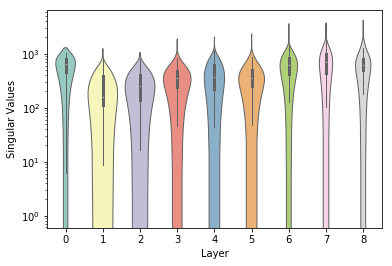

In [21]:
s = get_singular_values(trainer)
all_sigmas = np.concatenate(s)
all_layers = np.concatenate([len(s[i])*[i] for i in range(len(s))])
df = pd.DataFrame({'Singular Values':all_sigmas,'Layer':all_layers})
#df = pd.DataFrame.from_dict({f'Layer {i}':s[i] for i in range(len(s))}, orient='index')
# for i in range(len(s)):
#     singulars = np.random.choice(s[i],300)
#     plt.scatter(i*np.ones_like(singulars),singulars)
sb.violinplot(data=df,x='Layer',y='Singular Values',palette="Set3", bw=1, cut=1, linewidth=1)
plt.yscale('log')
# plt.xlabel("Layer")
# plt.ylabel(r"Eigenvalues")

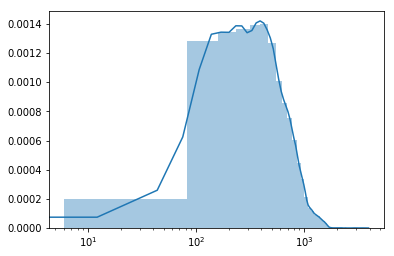

In [20]:
sb.distplot(all_sigmas)
plt.xscale('log')

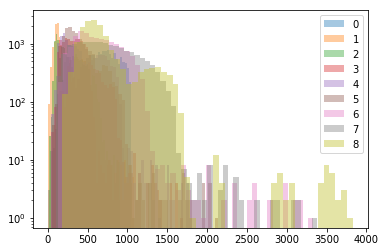

In [19]:
for i in range(len(s)):
    sb.distplot(s[i],kde=False,label=i)
plt.yscale('log')
#plt.xscale('log')
plt.legend()

In [ ]:
h = 32
channels = 32
s = []
i = 0
for module in trainer.model[1].modules():
    if isinstance(module,SN):
        s_ = module._s
        i+=1
        if i==3:break
    if isinstance(module,nn.Conv2d):
        if module.weight.shape[0]>channels:
            h//=2
            channels = module.weight.shape[0]
        
#         w2 = F.pad(w,(0,h-3,0,h-3))
#         print(w2.shape)

In [ ]:
weight = module.module.weight.cpu().data.clone()#/torch.max(module._s.cpu(),torch.tensor(1.))

In [ ]:
weight = weight.data.permute((2,3,0,1)).numpy()

In [ ]:
np.pad(weight,((0,0),(0,0),(1,1),(1,1)),mode='constant').shape

In [ ]:
h,w = module.input_shape[:2]

In [ ]:
sigmas = singularValues(weight,(h+2,w+2)).reshape(-1)

In [ ]:
sb.distplot(sigmas)

In [ ]:
module.training=True
test_in = torch.zeros_like(module._u)
module._u = None
sigma_est = []
with torch.no_grad():
    for k in range(100):
        test_out = module(test_in)
        sigma_est.append(module._s)
plt.plot(sigma_est)

In [ ]:
module.input_shape

In [24]:
%lprun -f singularValues get_singular_values(trainer)

Timer unit: 1e-06 s

Total time: 2.73757 s
File: <ipython-input-23-85dd3ccd3b72>
Function: singularValues at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def singularValues(kernel,input_shape):
     6         9     353196.0  39244.0     12.9      transforms = np.fft.fft2(kernel,input_shape,axes=(0,1))
     7         9    2384363.0 264929.2     87.1      u,s,vh = np.linalg.svd(transforms)#,compute_uv=False)
     8         9         12.0      1.3      0.0      return s